In [21]:
import pandas as pd
import pickle as pkl
import numpy as np

import matplotlib.pyplot as plt

import scanpy as sc
%matplotlib inline
import matplotlib

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


### Random baseline

In [22]:
def generate_random_rounds(all_genes, round0=None, rounds = 16, sample_size=64):
    past_set =list(all_genes)
    random_rounds = {}
    if round0 is not None:
        random_rounds[0] = round0
    else:
        random_rounds[0] = np.random.choice(all_genes, sample_size)
    
    for i in range(1,rounds):
        selection_set = set(past_set).difference(set(random_rounds[i-1]))
        random_rounds[i] = np.concatenate([random_rounds[i-1], np.random.choice(list(selection_set), sample_size)])
        past_set = list(selection_set)
        
    return random_rounds

def generate_random_rounds_custom(all_genes, rounds = 16, sample_sizes=None):
    past_set =list(all_genes)
    random_rounds = {}
    random_rounds[0] = []
    
    for i in range(1,rounds):
        selection_set = set(past_set).difference(set(random_rounds[i-1]))
        random_rounds[i] = np.concatenate([random_rounds[i-1], np.random.choice(list(selection_set), sample_sizes[i])])
        past_set = list(selection_set)
        
    return random_rounds

def return_hits(list_):
    return list(set(list_).intersection(set(topmovers)))

def get_all_sampled_genes(exp_path, num_rounds = 100):
    all_sampled_genes = []
    for i in range(1,num_rounds):
        exp_path_ = exp_path + str(i) + '.npy'
        all_sampled_genes.append(np.load(exp_path_))
    return all_sampled_genes

def get_successful_sample_sizes(sampled_genes):
    sizes = []
    prev_size = 0
    for sample in sampled_genes:
        sizes.append(len(sample)-prev_size)
        prev_size = prev_size + sizes[-1]
    return sizes

def return_hits(arr):
    return list(set(arr).intersection(set(topmovers)))

In [53]:
REPS = ['1', '2']
ACQUISITION_FUNCTIONS = ["random", "softuncertain", "topuncertain",
                         "marginsample", "coreset", "badge",
                         "kmeans_embedding", "kmeans_data"]
        #"adversarialBIM", "custom"
#ACQUISITION_FUNCTIONS = ["topuncertain"]
SCREEN_NAMES = ['Adenosine', 'TGFb', 'Cyclosporine', 'Tacrolimus']

num_reps = len(REPS)
sample_size=32
num_steps = 30

screen_name = SCREEN_NAMES[1]
data_name = 'Carnevale_2022_' + screen_name

data_df = pd.read_csv('/dfs/user/yhr/research_assistant/datasets/ground_truth_Carnevale22_'+screen_name+'.csv')
topmovers = np.load('/dfs/user/yhr/research_assistant/datasets/topmovers_Carnevale22_'+screen_name+'.npy')
all_genes = data_df['Gene'].values

### ML Models

In [54]:
def read_ml_rounds(data_name, num_steps):
    path = '/dfs/user/yhr/genedisco/genedisco/results/'+data_name+'/'
    all_pred_genes = []
    for i in range(num_steps):
        try:
            all_pred_genes.append(pd.read_pickle(path+'cycle_{}/selected_indices.pickle'.format(i)))
        except:
            print('No sampling round {}'.format(i))
    return all_pred_genes

def get_ml_hits(data_name, ML_model_name, num_steps = 40, num_reps=2):
    
    ml_rounds = {}
    ml_hits = {}
    ml_hit_rates = {}
    
    for rep in range(1, num_reps+1):
        rep=str(rep)
        ml_rounds[rep] = read_ml_rounds(data_name + '_' + ML_model_name + '_{}'.format(rep), num_steps)

        ml_hits[rep] = []
        ml_hit_rates[rep] = []
        for step in range(num_steps):
            ml_hits[rep].append(return_hits(ml_rounds[rep][step]))
            ml_hit_rates[rep].append(len(ml_hits[rep][-1])/len(topmovers))
        
    return ml_hit_rates, ml_hits


def get_random_hits(sample_size, num_steps = 40, num_reps=3):
    random_rounds = {}
    random_hits = {}
    random_hit_rates = {}

    for rep in range(1, num_reps+1):
        rep=str(rep)
        random_rounds[rep] = generate_random_rounds(all_genes, rounds = num_steps, sample_size=sample_size)
        #random_rounds[rep] = generate_random_rounds_custom(all_genes, rounds = num_steps, 
        #                                                   sample_sizes=sample_sizes[rep])

        random_hits[rep] = []
        random_hit_rates[rep] = []
        for step in range(num_steps):
            random_hits[rep].append(return_hits(random_rounds[rep][step]))
            random_hit_rates[rep].append(len(random_hits[rep][-1])/len(topmovers))
            
    return random_hit_rates, random_hits

In [55]:
# calculate the mean and standard deviation of the random data
random_hit_rates, random_hits = get_random_hits(sample_size, num_steps = num_steps, num_reps=num_reps)
random_mean = np.mean(np.array([x for x in random_hit_rates.values()]),0)
random_std = np.std(np.array([x for x in random_hit_rates.values()]),0)

# calculate the mean and standard deviation for the model predictions
ml_mean = {}
ml_std = {}

for ML_model_name in ACQUISITION_FUNCTIONS:
    
    print(ML_model_name)
    
    try:
        ml_hit_rates, ml_hits = get_ml_hits(data_name, ML_model_name, num_steps = num_steps, num_reps=num_reps)
        ml_mean[ML_model_name] = np.mean(np.array([x for x in ml_hit_rates.values()]),0)
        ml_std[ML_model_name] = np.std(np.array([x for x in ml_hit_rates.values()]),0)
    except:
        print('Failed')

random
softuncertain
topuncertain
marginsample
coreset
badge
No sampling round 0
No sampling round 1
No sampling round 2
No sampling round 3
No sampling round 4
No sampling round 5
No sampling round 6
No sampling round 7
No sampling round 8
No sampling round 9
No sampling round 10
No sampling round 11
No sampling round 12
No sampling round 13
No sampling round 14
No sampling round 15
No sampling round 16
No sampling round 17
No sampling round 18
No sampling round 19
No sampling round 20
No sampling round 21
No sampling round 22
No sampling round 23
No sampling round 24
No sampling round 25
No sampling round 26
No sampling round 27
No sampling round 28
No sampling round 29
Failed
kmeans_embedding
kmeans_data
No sampling round 9
No sampling round 10
No sampling round 11
No sampling round 12
No sampling round 13
No sampling round 14
No sampling round 15
No sampling round 16
No sampling round 17
No sampling round 18
No sampling round 19
No sampling round 20
No sampling round 21
No sampling

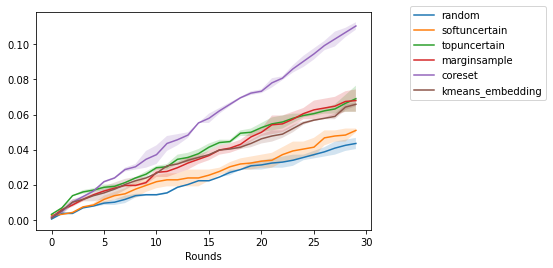

In [56]:
# create the plot
#plt.plot(np.arange(num_steps), random_mean, label='Random_new')
#plt.fill_between(np.arange(num_steps), random_mean - random_std, 
#                         random_mean + random_std, alpha=0.2)

for ML_model_name in ACQUISITION_FUNCTIONS:
    try:
        plt.plot(np.arange(num_steps), ml_mean[ML_model_name], label=ML_model_name)
        plt.fill_between(np.arange(num_steps), ml_mean[ML_model_name] - ml_std[ML_model_name], 
                                 ml_mean[ML_model_name] + ml_std[ML_model_name], alpha=0.2)
    except:
        continue

# set the x-axis labels and tick marks
plt.xlabel('Rounds')

# add a legend to the plot
plt.legend(bbox_to_anchor=(1.1, 1.05))

# display the plot
plt.show()

### Equal sampling: Claude

In [4]:
import glob

exp_paths = {
 '1':'/dfs/user/yhr/research_assistant/logs_Belk22/exp1/sampled_genes_',
 '2':'/dfs/user/yhr/research_assistant/logs_Belk22/exp2/sampled_genes_',
 '3':'/dfs/user/yhr/research_assistant/logs_Belk22/exp4/sampled_genes_',
}

In [5]:
sampled_genes = {}
sample_sizes = {}
hits = {}
hit_rates = {}
num_rounds = 35
filter_zero_sets = True

for rep in range(1, len(exp_paths)+1):
    rep = str(rep)
    sampled_genes[rep] = get_all_sampled_genes(exp_paths[rep], num_rounds=num_rounds)
    sample_sizes[rep] = get_successful_sample_sizes(sampled_genes[rep])
    if filter_zero_sets:
         sampled_genes[rep] = [sampled_genes[rep][itr] for itr in np.where(np.array(sample_sizes[rep])!= 0)[0]]
    
    hits[rep] = []
    hit_rates[rep] = []
    hits[rep] = [return_hits(x) for x in sampled_genes[rep]]
    hit_rates[rep] = [len(x)/len(topmovers) for x in hits[rep]]

<BarContainer object of 34 artists>

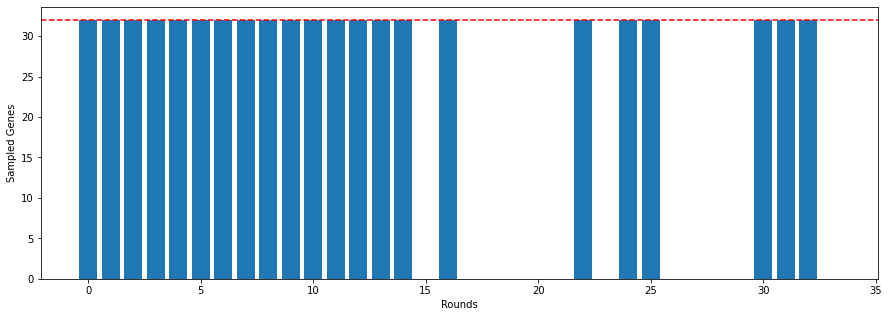

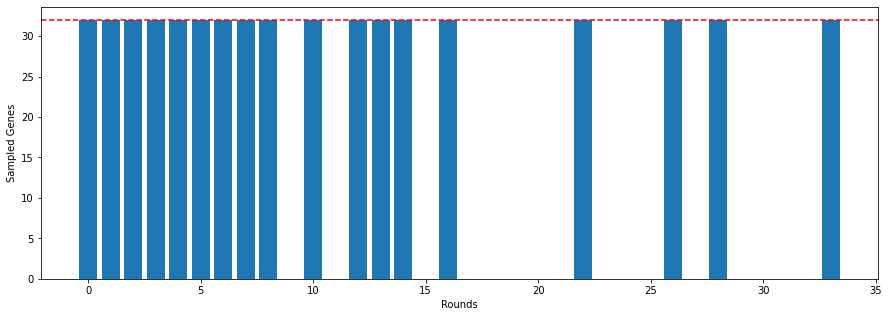

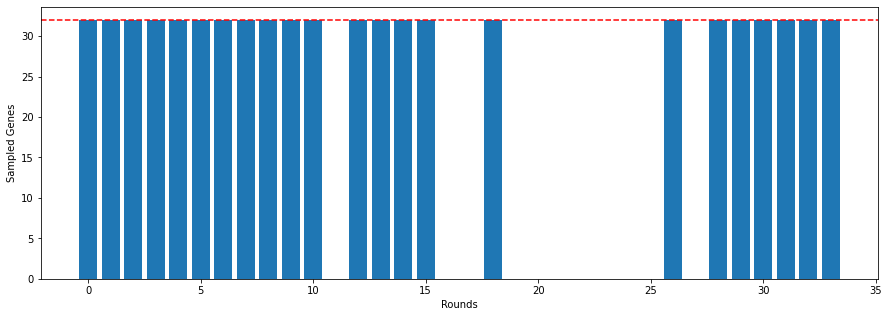

In [34]:
## GPT has trouble counting

plt.figure(figsize=[15,5])
plt.ylabel('Sampled Genes')
plt.xlabel('Rounds')
plt.axhline(y=32, color='r', linestyle='--')
plt.bar(range(len(sample_sizes['1'])), sample_sizes['1'])

plt.figure(figsize=[15,5])
plt.ylabel('Sampled Genes')
plt.xlabel('Rounds')
plt.axhline(y=32, color='r', linestyle='--')
plt.bar(range(len(sample_sizes['1'])), sample_sizes['2'])

plt.figure(figsize=[15,5])
plt.ylabel('Sampled Genes')
plt.xlabel('Rounds')
plt.axhline(y=32, color='r', linestyle='--')
plt.bar(range(len(sample_sizes['1'])), sample_sizes['3'])

In [7]:
random_rounds = {}
random_hits = {}
random_hit_rates = {}

for rep in range(1, len(exp_paths)+1):
    rep=str(rep)
    random_rounds[rep] = generate_random_rounds(all_genes, rounds = num_steps, sample_size=sample_size)
    #random_rounds[rep] = generate_random_rounds_custom(all_genes, rounds = num_steps, 
    #                                                   sample_sizes=sample_sizes[rep])
    
    random_hits[rep] = []
    random_hit_rates[rep] = []
    for step in range(num_steps):
        random_hits[rep].append(return_hits(random_rounds[rep][step]))
        random_hit_rates[rep].append(len(random_hits[rep][-1])/len(topmovers))
        
# calculate the mean and standard deviation of the random data
random_mean = np.mean(np.array([x for x in random_hit_rates.values()]),0)
random_std = np.std(np.array([x for x in random_hit_rates.values()]),0)

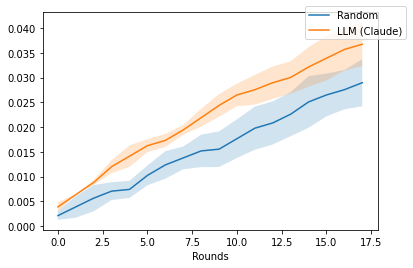

In [8]:
import matplotlib.pyplot as plt
import numpy as np


ai_ra_mean_claude = np.mean(np.array([x[:num_steps] for x in hit_rates.values()]),0)
ai_ra_std_claude = np.std(np.array([x[:num_steps] for x in hit_rates.values()]),0)


# create the plot
plt.plot(np.arange(num_steps), random_mean, label='Random')
plt.fill_between(np.arange(num_steps), random_mean - random_std, 
                         random_mean + random_std, alpha=0.2)

# add the GPT data to the plot
plt.plot(np.arange(num_steps), ai_ra_mean_claude, label='LLM (Claude)')
plt.fill_between(np.arange(num_steps), ai_ra_mean_claude - ai_ra_std_claude, 
                             ai_ra_mean_claude + ai_ra_std_claude, alpha=0.2)

# set the x-axis labels and tick marks
plt.xlabel('Rounds')

# add a legend to the plot
plt.legend(bbox_to_anchor=(1.1, 1.05))

# display the plot
plt.show()

### Combined plot

In [70]:
random_rounds = {}
random_hits = {}
random_hit_rates = {}

num_steps = max(len(ai_ra_mean_gpt35),
len(ai_ra_mean_gpt4),
len(ai_ra_mean_claude),
len(ml_mean))

for rep in range(1, len(exp_paths)+1):
    rep=str(rep)
    random_rounds[rep] = generate_random_rounds(all_genes, rounds = num_steps, sample_size=sample_size)
    #random_rounds[rep] = generate_random_rounds_custom(all_genes, rounds = num_steps, 
    #                                                   sample_sizes=sample_sizes[rep])
    
    random_hits[rep] = []
    random_hit_rates[rep] = []
    for step in range(num_steps):
        random_hits[rep].append(return_hits(random_rounds[rep][step]))
        random_hit_rates[rep].append(len(random_hits[rep][-1])/len(topmovers))
        
# calculate the mean and standard deviation of the random data
random_mean = np.mean(np.array([x for x in random_hit_rates.values()]),0)
random_std = np.std(np.array([x for x in random_hit_rates.values()]),0)

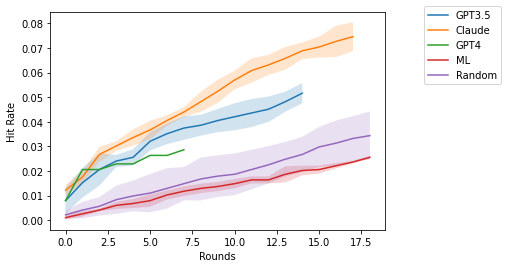

In [71]:
# add the GPT data to the plot

num_steps = len(ai_ra_mean_gpt35)
plt.plot(np.arange(num_steps), ai_ra_mean_gpt35, label='GPT3.5')
plt.fill_between(np.arange(num_steps), ai_ra_mean_gpt35 - ai_ra_std_gpt35, 
                             ai_ra_mean_gpt35 + ai_ra_std_gpt35, alpha=0.2)


num_steps = len(ai_ra_mean_claude)
plt.plot(np.arange(num_steps), ai_ra_mean_claude, label='Claude')
plt.fill_between(np.arange(num_steps), ai_ra_mean_claude - ai_ra_std_claude, 
                             ai_ra_mean_claude + ai_ra_std_claude, alpha=0.2)


num_steps = len(ai_ra_mean_gpt4)
plt.plot(np.arange(num_steps), ai_ra_mean_gpt4, label='GPT4')
plt.fill_between(np.arange(num_steps), ai_ra_mean_gpt4 - ai_ra_std_gpt4, 
                             ai_ra_mean_gpt4 + ai_ra_std_gpt4, alpha=0.2)


num_steps = len(ml_mean)
plt.plot(np.arange(num_steps), ml_mean, label='ML')
plt.fill_between(np.arange(num_steps), ml_mean - ml_std, 
                             ml_mean + ml_std, alpha=0.2)



num_steps = len(random_mean)
plt.plot(np.arange(num_steps), random_mean, label='Random')
plt.fill_between(np.arange(num_steps), random_mean - random_std, 
                         random_mean + random_std, alpha=0.2)

# set the x-axis labels and tick marks
plt.xlabel('Rounds')
plt.ylabel('Hit Rate')

# add a legend to the plot
plt.legend(bbox_to_anchor=(1.1, 1.05))

# display the plot
plt.show()